In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score


import joblib



In [6]:
df = pd.read_csv("human_vital_signs_dataset_2024.csv")
df.head()


,Patient ID,Heart Rate,Respiratory Rate,Timestamp,Body Temperature,Oxygen Saturation,Systolic Blood Pressure,Diastolic Blood Pressure,Age,Gender,Weight (kg),Height (m),Derived_HRV,Derived_Pulse_Pressure,Derived_BMI,Derived_MAP,Risk Category
0,1,60,12,2024-07-19 21:53:45.729841,36.861707,95.702046,124,86,37,Female,91.541618,1.679351,0.121033,38,32.459031,98.666667,High Risk
1,2,63,18,2024-07-19 21:52:45.729841,36.511633,96.689413,126,84,77,Male,50.704921,1.992546,0.117062,42,12.771246,98.000000,High Risk
2,3,63,15,2024-07-19 21:51:45.729841,37.052049,98.508265,131,78,68,Female,90.316760,1.770228,0.053200,53,28.821069,95.666667,Low Risk
3,4,99,16,2024-07-19 21:50:45.729841,36.654748,95.011801,118,72,41,Female,96.006188,1.833629,0.064475,46,28.554611,87.333333,High Risk
4,5,69,16,2024-07-19 21:49:45.729841,36.975098,98.623792,138,76,25,Female,56.020006,1.866419,0.118484,62,16.081438,96.666667,High Risk


In [7]:
le = LabelEncoder()
df["Risk_Label"] = le.fit_transform(df["Risk Category"])
# Low Risk = 0, High Risk = 1


In [8]:
unsup_features = [
    "Heart Rate",
    "Respiratory Rate",
    "Body Temperature",
    "Oxygen Saturation",
    "Derived_HRV",
    "Derived_MAP",
    "Derived_Pulse_Pressure"
]


In [9]:
normal_df = df[df["Risk_Label"] == 0]

unsup_features = [
    "Heart Rate",
    "Respiratory Rate",
    "Body Temperature",
    "Oxygen Saturation",
    "Derived_HRV",
    "Derived_MAP",
    "Derived_Pulse_Pressure"
]

scaler = StandardScaler()
X_unsup_train = scaler.fit_transform(normal_df[unsup_features])

iso_model = IsolationForest(
    n_estimators=200,
    contamination=0.08,
    random_state=42
)

iso_model.fit(X_unsup_train)


IsolationForest(contamination=0.08, n_estimators=200, random_state=42)

In [10]:
X_all_scaled = scaler.transform(df[unsup_features])
df["anomaly_score"] = -iso_model.decision_function(X_all_scaled)


In [11]:
df["anomaly_percentile"] = df["anomaly_score"].rank(pct=True)


In [12]:
sup_features = [
    "anomaly_percentile",
    "Derived_HRV",
    "Derived_MAP",
    "Derived_Pulse_Pressure",
    "Oxygen Saturation"
]


In [13]:
X = df[sup_features]
y = df["Risk_Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=50, n_estimators=300, random_state=42)

In [33]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.55      0.63      0.58     21023
           1       0.51      0.42      0.46     18981

    accuracy                           0.53     40004
   macro avg       0.53      0.53      0.52     40004
weighted avg       0.53      0.53      0.53     40004



In [34]:
risk_prob = rf_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, risk_prob)

print("ROC-AUC Score:", roc_auc)


ROC-AUC Score: 0.5307872056145251


In [35]:
import numpy as np

risk_probs = rf_model.predict_proba(df[sup_features])[:, 1]

df["Predicted_Risk_Level"] = np.where(
    risk_probs < 0.3, "Normal",
    np.where(risk_probs < 0.6, "Warning", "Critical")
)


In [36]:
df[[
    "Risk Category",
    "anomaly_percentile",
    "Predicted_Risk_Level"
]].sample(10)


,Risk Category,anomaly_percentile,Predicted_Risk_Level
110507,High Risk,0.259044,Warning
17067,High Risk,0.591591,Warning
33252,Low Risk,0.489691,Warning
142066,High Risk,0.573308,Warning
69783,High Risk,0.017033,Warning
60281,High Risk,0.888681,Warning
98222,Low Risk,0.038491,Warning
110891,Low Risk,0.681577,Warning
119236,Low Risk,0.719543,Warning
23036,High Risk,0.749735,Warning


In [37]:
pd.Series(risk_probs).describe()


count    200020.000000
mean          0.499484
std           0.032079
min           0.366028
25%           0.479505
50%           0.493189
75%           0.516891
max           0.665408
dtype: float64

In [38]:
np.percentile(risk_probs, [10, 25, 50, 75, 90])


array([0.4669789 , 0.47950491, 0.4931891 , 0.51689125, 0.54297744])

In [39]:
p70 = np.percentile(risk_probs, 70)
p90 = np.percentile(risk_probs, 90)

df["Predicted_Risk_Level"] = np.where(
    risk_probs < p70, "Normal",
    np.where(risk_probs < p90, "Warning", "Critical")
)


In [40]:
df["Predicted_Risk_Level"] = np.where(
    (df["anomaly_percentile"] > 0.9) & (risk_probs > 0.6),
    "Critical",
    np.where(
        (df["anomaly_percentile"] > 0.5) | (risk_probs > 0.5),
        "Warning",
        "Normal"
    )
)


In [41]:
df[[
    "Risk Category",
    "anomaly_percentile",
    "Predicted_Risk_Level"
]].sample(10)

,Risk Category,anomaly_percentile,Predicted_Risk_Level
53442,Low Risk,0.381102,Normal
80770,High Risk,0.116313,Normal
31638,Low Risk,0.335201,Normal
47546,Low Risk,0.528487,Warning
91621,High Risk,0.805854,Warning
21305,Low Risk,0.296945,Warning
86621,High Risk,0.557274,Warning
127940,Low Risk,0.651645,Warning
54740,High Risk,0.814854,Warning
116467,High Risk,0.769323,Warning


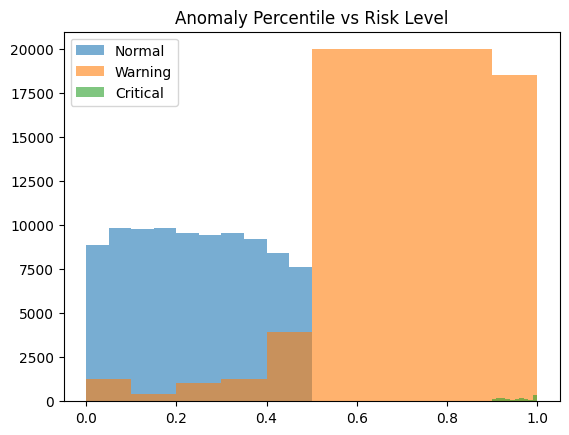

In [42]:
import matplotlib.pyplot as plt

plt.hist(
    df[df["Predicted_Risk_Level"]=="Normal"]["anomaly_percentile"],
    alpha=0.6, label="Normal"
)
plt.hist(
    df[df["Predicted_Risk_Level"]=="Warning"]["anomaly_percentile"],
    alpha=0.6, label="Warning"
)
plt.hist(
    df[df["Predicted_Risk_Level"]=="Critical"]["anomaly_percentile"],
    alpha=0.6, label="Critical"
)

plt.legend()
plt.title("Anomaly Percentile vs Risk Level")
plt.show()


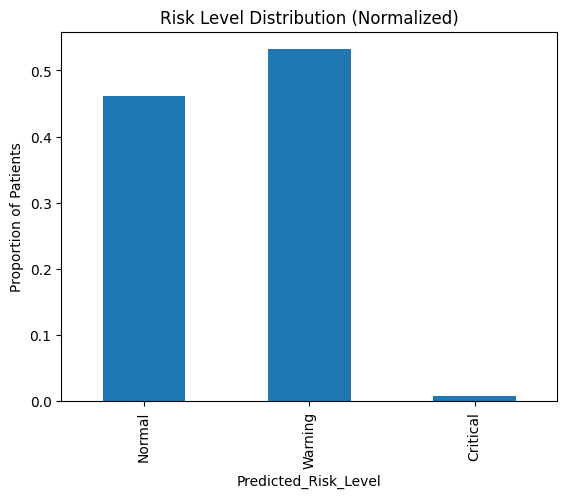

In [43]:
import matplotlib.pyplot as plt

levels = ["Normal", "Warning", "Critical"]
counts = df["Predicted_Risk_Level"].value_counts(normalize=True).reindex(levels)

plt.figure()
counts.plot(kind="bar")
plt.ylabel("Proportion of Patients")
plt.title("Risk Level Distribution (Normalized)")
plt.show()


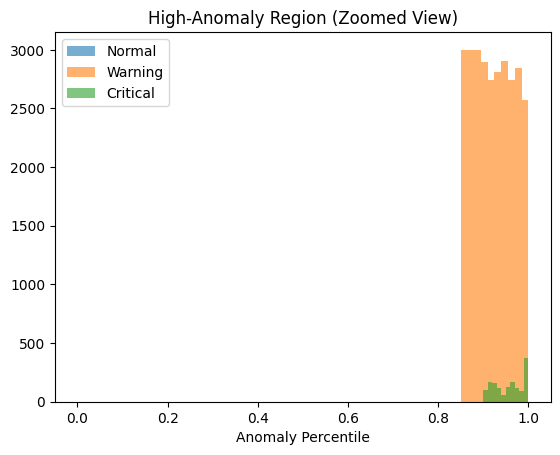

In [44]:
plt.figure()

subset = df[df["anomaly_percentile"] > 0.85]

for level in ["Normal", "Warning", "Critical"]:
    plt.hist(
        subset[subset["Predicted_Risk_Level"] == level]["anomaly_percentile"],
        alpha=0.6,
        label=level
    )

plt.legend()
plt.title("High-Anomaly Region (Zoomed View)")
plt.xlabel("Anomaly Percentile")
plt.show()


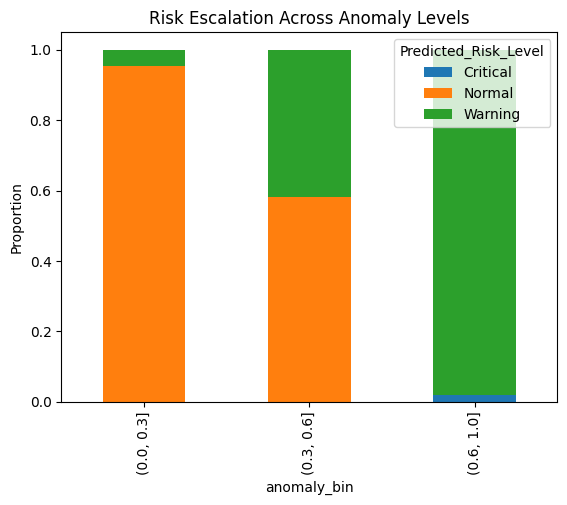

In [45]:
bins = [0, 0.3, 0.6, 1.0]
df["anomaly_bin"] = pd.cut(df["anomaly_percentile"], bins)

risk_counts = df.groupby(["anomaly_bin", "Predicted_Risk_Level"]).size().unstack().fillna(0)
risk_percent = risk_counts.div(risk_counts.sum(axis=1), axis=0)

risk_percent.plot(kind="bar", stacked=True)
plt.ylabel("Proportion")
plt.title("Risk Escalation Across Anomaly Levels")
plt.show()


In [46]:
df[
    [
        "Risk Category",
        "anomaly_percentile",
        "Predicted_Risk_Level"
    ]
].sample(8)


,Risk Category,anomaly_percentile,Predicted_Risk_Level
606,Low Risk,0.498435,Normal
126366,Low Risk,0.203175,Normal
37961,High Risk,0.329287,Normal
116316,High Risk,0.501905,Warning
49931,Low Risk,0.461304,Normal
164501,High Risk,0.109274,Normal
26003,Low Risk,0.180192,Normal
69825,High Risk,0.312984,Normal


In [47]:
importance = pd.Series(
    rf_model.feature_importances_,
    index=sup_features
).sort_values(ascending=False)

importance


anomaly_percentile        0.316894
Oxygen Saturation         0.228211
Derived_HRV               0.223508
Derived_MAP               0.121028
Derived_Pulse_Pressure    0.110358
dtype: float64

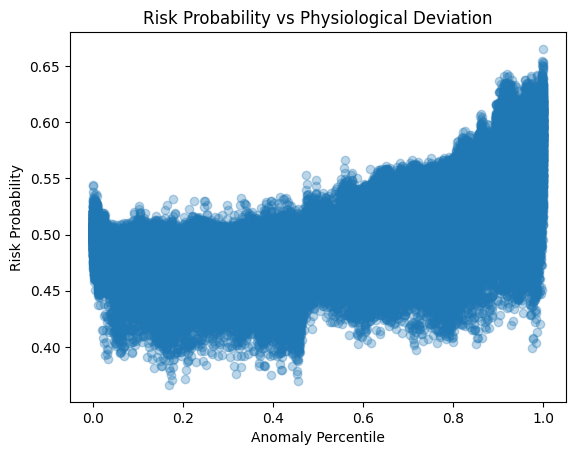

In [48]:
plt.figure()
plt.scatter(df["anomaly_percentile"], risk_probs, alpha=0.3)
plt.xlabel("Anomaly Percentile")
plt.ylabel("Risk Probability")
plt.title("Risk Probability vs Physiological Deviation")
plt.show()


In [49]:
df = df.sort_values(["Patient ID", "Timestamp"])

for col in ["Heart Rate", "Oxygen Saturation", "Body Temperature"]:
    df[f"{col}_baseline"] = (
        df.groupby("Patient ID")[col]
        .transform(lambda x: x.rolling(10, min_periods=5).mean())
    )
    df[f"{col}_delta"] = df[col] - df[f"{col}_baseline"]


In [21]:
import shap
import numpy as np
import pandas as pd

X_shap = X_test.sample(500, random_state=42)

explainer = shap.Explainer(rf_model, X_shap)
shap_values = explainer(X_shap)


 99%|===================| 994/1000 [01:33<00:00]        

In [23]:
import numpy as np
import pandas as pd

# Mean absolute SHAP for positive class
shap_importance = np.abs(shap_values.values[:, :, 1]).mean(axis=0)

shap_df = pd.DataFrame({
    "Feature": sup_features,
    "Mean |SHAP value|": shap_importance
}).sort_values(by="Mean |SHAP value|", ascending=False)

shap_df


,Feature,Mean |SHAP value|
0,anomaly_percentile,0.028303
1,Derived_HRV,0.008286
4,Oxygen Saturation,0.008181
3,Derived_Pulse_Pressure,0.006794
2,Derived_MAP,0.004795


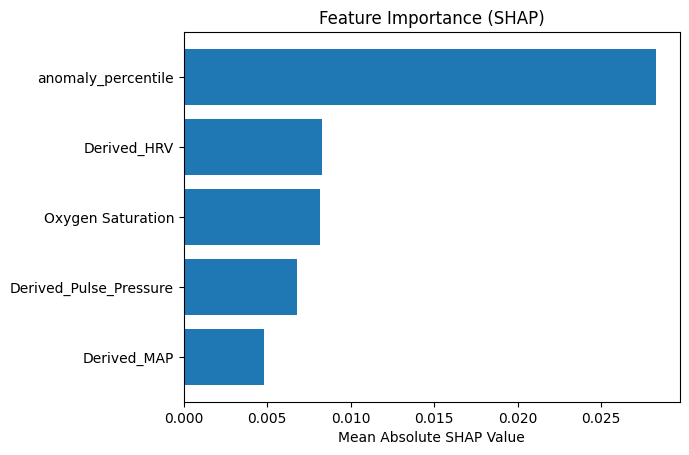

In [24]:
import matplotlib.pyplot as plt

plt.figure()
plt.barh(
    shap_df["Feature"],
    shap_df["Mean |SHAP value|"]
)
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Feature Importance (SHAP)")
plt.gca().invert_yaxis()
plt.show()


In [26]:
import joblib
from datetime import datetime

model_bundle = {
    "iso_model": iso_model,
    "scaler": scaler,
    "rf_model": rf_model,

    # Feature configuration
    "unsup_features": unsup_features,
    "sup_features": sup_features,

    # Risk decision thresholds
    "thresholds": {
        "anomaly_warning": 0.5,
        "anomaly_critical": 0.9,
        "risk_warning": 0.5,
        "risk_critical": 0.6
    },

    # Metadata
    "version": "v1.0",
    "created_at": datetime.now().isoformat(),
    "notes": "Hybrid unsupervised + supervised early health risk model"
}


In [27]:
joblib.dump(model_bundle, "health_risk_pipeline_v1.pkl")


['health_risk_pipeline_v1.pkl']

In [28]:
loaded_bundle = joblib.load("health_risk_pipeline_v1.pkl")

print(loaded_bundle.keys())


dict_keys(['iso_model', 'scaler', 'rf_model', 'unsup_features', 'sup_features', 'thresholds', 'version', 'created_at', 'notes'])
